# Segundo Punto - Clustering Jerárquico con el Dataset Seeds

En este notebook, se explorarán las relaciones naturales entre diferentes variedades de semillas de trigo del dataset **Seeds** utilizando clustering jerárquico. Se aplicarán varios criterios de enlace (`linkage`) para construir dendrogramas, se analizarán los puntos de corte y se utilizarán métricas cuantitativas para determinar el número óptimo de clusters.

## 1. Carga de Datos y Librerías

Primero, se importan las librerías necesarias y se carga el dataset `Seeds` desde el repositorio de UCI.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Cargar los datos desde la URL
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'
column_names = [
    'area', 'perimeter', 'compactness', 'length_of_kernel', 'width_of_kernel',
    'asymmetry_coefficient', 'length_of_kernel_groove', 'class'
]
# Se utiliza sep='\s+' para manejar múltiples espacios como separadores
df = pd.read_csv(url, header=None, names=column_names, sep=r'\s+')

# Separar características (X) y etiquetas (y)
X = df.drop('class', axis=1)
y = df['class']

# Mostrar las primeras filas para verificar la carga
df.head()

,area,perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_kernel_groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


## 2. Preparación de Datos

El clustering jerárquico se basa en distancias, por lo que es fundamental escalar las características. Se utilizará `StandardScaler` para que todas las variables tengan media 0 y desviación estándar 1, asegurando que ninguna característica domine el análisis por su escala.

In [20]:
# Inicializar el escalador
scaler = StandardScaler()

# Ajustar y transformar los datos
X_scaled = scaler.fit_transform(X)

## 3. Clustering Jerárquico con Diferentes Enlaces

Se aplicará el clustering jerárquico aglomerativo con cuatro métodos de enlace (`linkage`) para comparar cómo afectan la estructura de los clusters:
- **Single**: Mide la distancia mínima entre clusters.
- **Complete**: Mide la distancia máxima entre clusters.
- **Average**: Mide la distancia promedio entre los puntos de los clusters.
- **Ward**: Minimiza la varianza dentro de los clusters que se fusionan.

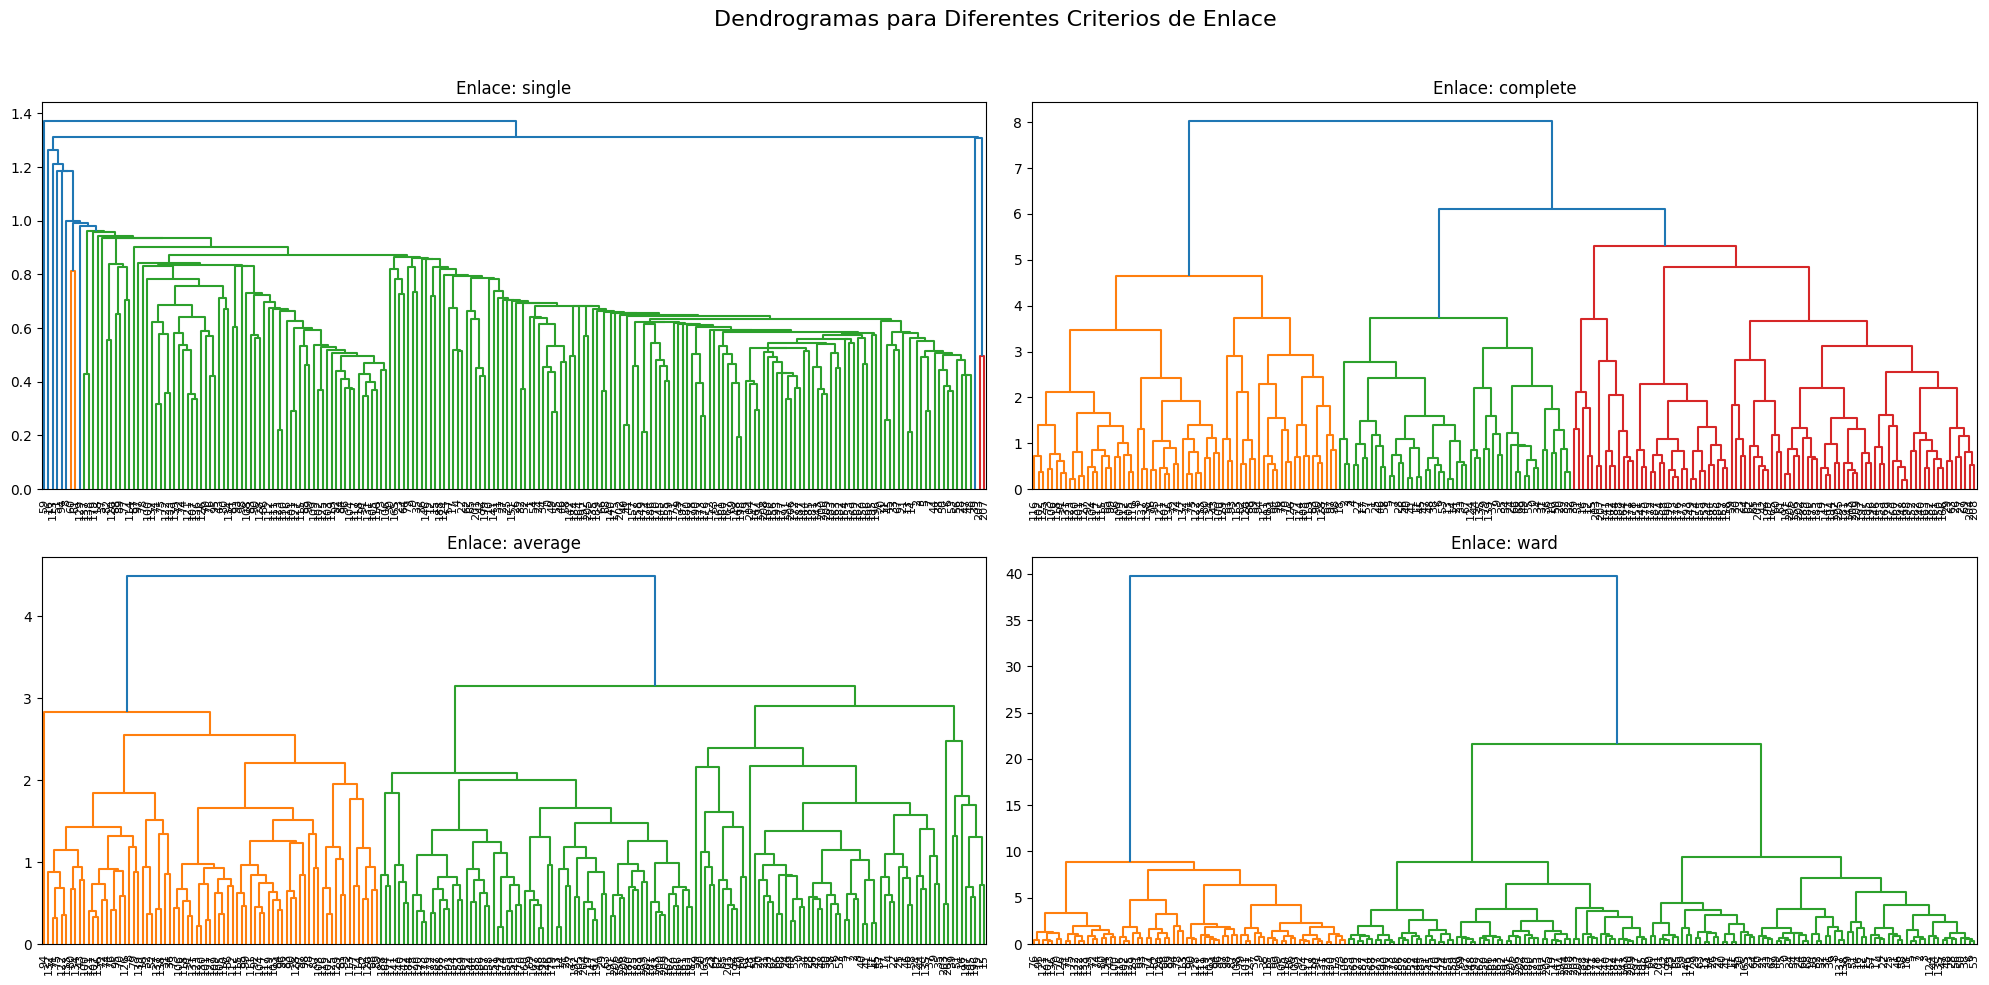

In [21]:
linkage_methods = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=(20, 10))
plt.suptitle('Dendrogramas para Diferentes Criterios de Enlace', fontsize=16)

for i, method in enumerate(linkage_methods):
    # Crear un subplot para cada método
    plt.subplot(2, 2, i + 1)
    plt.title(f'Enlace: {method}')
    
    # Calcular la matriz de enlace
    Z = linkage(X_scaled, method=method)
    
    # Generar el dendrograma
    dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

De los dendrogramas, se puede observar que el enlace **ward** parece producir los clusters más balanceados y bien separados, lo que es ideal para este tipo de análisis. Los otros métodos, como `single`, tienden a crear cadenas, mientras que `complete` y `average` ofrecen resultados intermedios.

## 4. Análisis de Puntos de Corte y Número Óptimo de Clusters

Basado en el análisis visual, se utilizará el dendrograma con enlace de **Ward** para analizar los puntos de corte. Además, se emplearán métricas cuantitativas como el **coeficiente de silueta**, el **índice de Calinski-Harabasz** y el criterio **J4** para validar la elección del número de clusters.

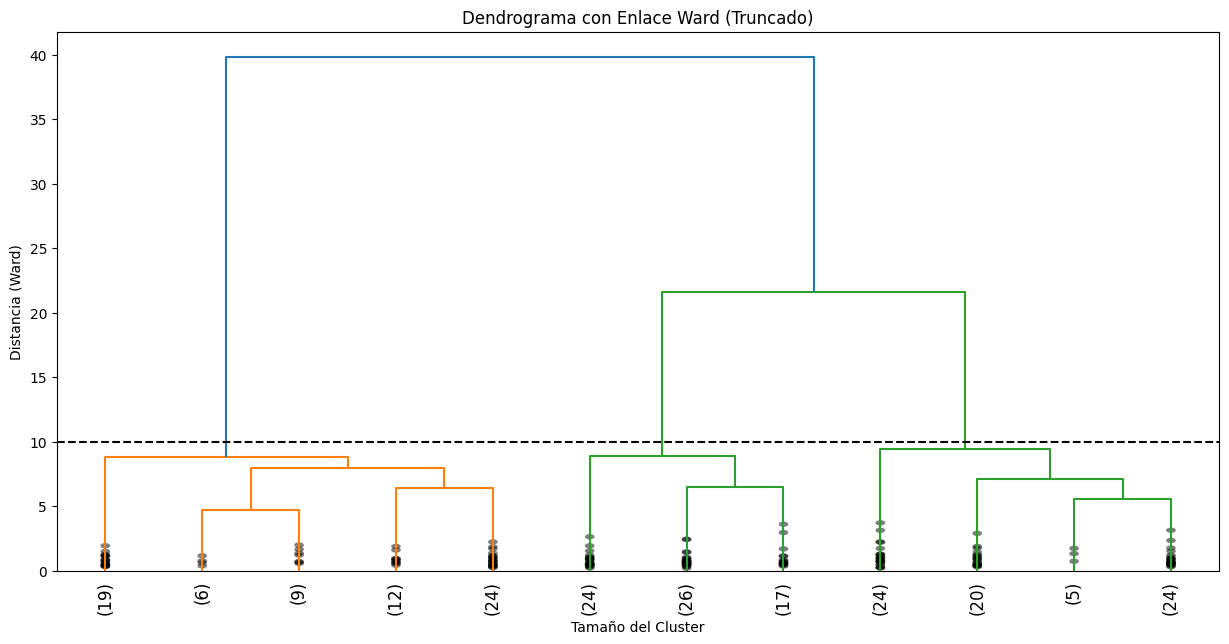

In [22]:
plt.figure(figsize=(15, 7))
plt.title('Dendrograma con Enlace Ward (Truncado)')
plt.xlabel('Tamaño del Cluster')
plt.ylabel('Distancia (Ward)')

# Calcular el enlace de Ward
Z_ward = linkage(X_scaled, method='ward')

# Graficar el dendrograma truncado para mayor claridad
dendrogram(
    Z_ward, 
    truncate_mode='lastp',  # Mostrar los últimos 'p' clusters fusionados
    p=12,                   # Número de clusters a mostrar en la parte inferior
    leaf_rotation=90., 
    leaf_font_size=12., 
    show_contracted=True    # Para representar el tamaño de los clusters
)

# Añadir una línea de corte para visualizar la formación de 3 clusters
plt.axhline(y=10, c='k', linestyle='--')
plt.show()

El dendrograma sugiere que un corte en una distancia de 10 (línea punteada) resultaría en **3 clusters**, lo cual coincide con el número real de clases en el dataset. A continuación, se valida esta hipótesis con métricas numéricas.

In [23]:
def calculate_j4(X, clusters):
    """Calcula el criterio J4 para una asignación de clusters dada."""
    media_total = np.mean(X, axis=0)
    
    # Convertir a DataFrame para usar groupby
    df = pd.DataFrame(X)
    df['cluster'] = clusters
    
    clases = df.groupby('cluster')
    
    medias = np.array(clases.mean())
    covarianzas = clases.cov()
    ni = clases.size()
    
    SB = np.zeros((X.shape[1], X.shape[1]))
    SW = np.zeros((X.shape[1], X.shape[1]))
    
    for j in range(len(medias)):
        mean_diff = (medias[j, :] - media_total).reshape(-1, 1)
        SB += (ni[j] / len(X)) * (mean_diff @ mean_diff.T)
        
        sigma_i = covarianzas.loc[j]
        SW += (ni[j] / len(X)) * sigma_i
        
    j4 = np.trace(SB) / np.trace(SW)
    
    return j4

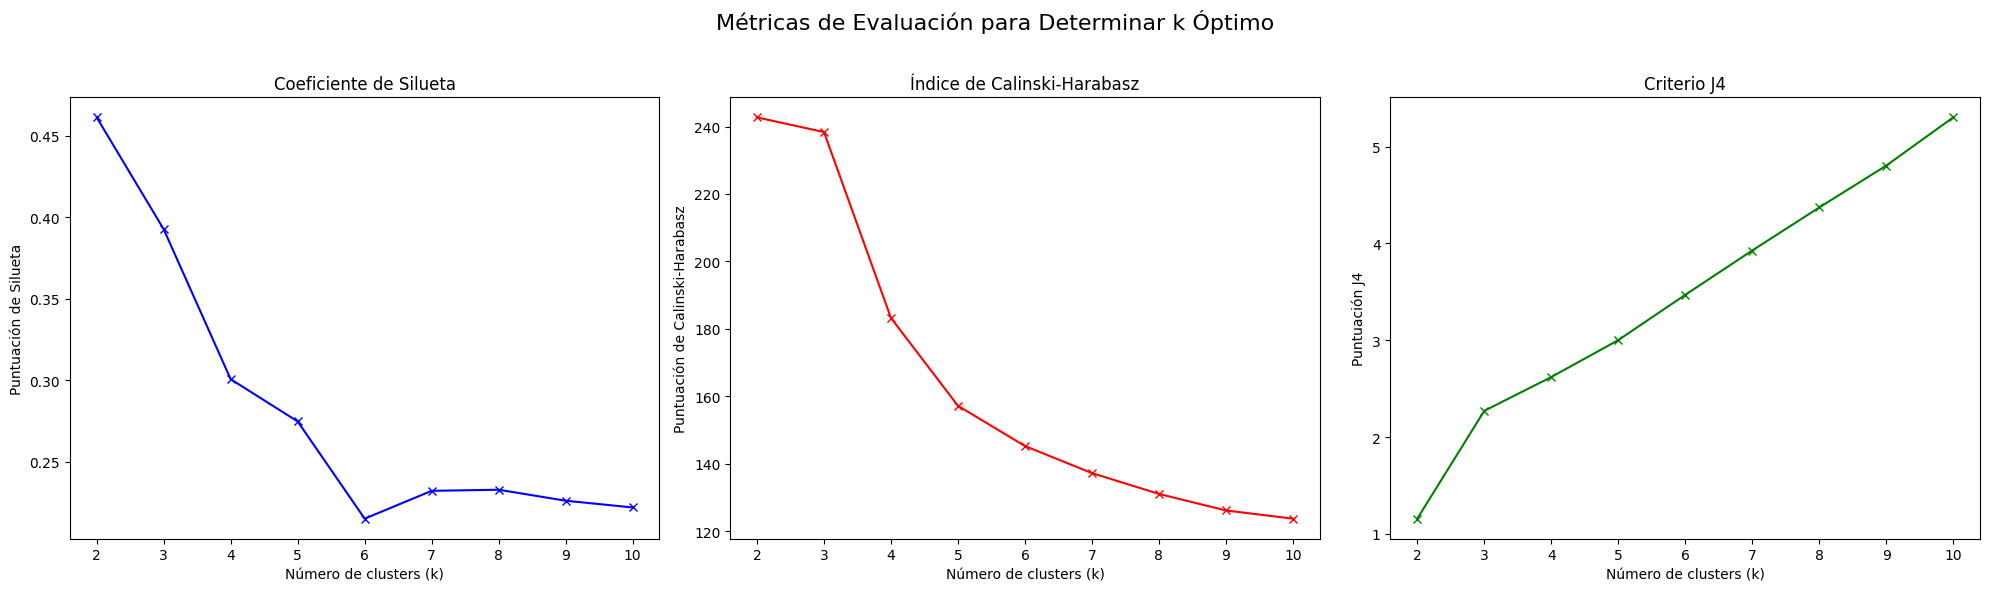

In [24]:
silhouette_scores = []
calinski_scores = []
j4_scores = []
range_n_clusters = list(range(2, 11))

for n_clusters in range_n_clusters:
    # Configurar el modelo de clustering aglomerativo
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = clusterer.fit_predict(X_scaled)
    
    # Calcular el coeficiente de silueta
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Calcular el índice de Calinski-Harabasz
    calinski_avg = calinski_harabasz_score(X_scaled, cluster_labels)
    calinski_scores.append(calinski_avg)
    
    # Calcular el criterio J4
    j4 = calculate_j4(X_scaled, cluster_labels)
    j4_scores.append(j4)

# Graficar los resultados de las métricas
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Métricas de Evaluación para Determinar k Óptimo', fontsize=16)

# Gráfico del Coeficiente de Silueta
ax1.plot(range_n_clusters, silhouette_scores, 'bx-')
ax1.set_title('Coeficiente de Silueta')
ax1.set_xlabel('Número de clusters (k)')
ax1.set_ylabel('Puntuación de Silueta')

# Gráfico del Índice de Calinski-Harabasz
ax2.plot(range_n_clusters, calinski_scores, 'rx-')
ax2.set_title('Índice de Calinski-Harabasz')
ax2.set_xlabel('Número de clusters (k)')
ax2.set_ylabel('Puntuación de Calinski-Harabasz')

# Gráfico del Criterio J4
ax3.plot(range_n_clusters, j4_scores, 'gx-')
ax3.set_title('Criterio J4')
ax3.set_xlabel('Número de clusters (k)')
ax3.set_ylabel('Puntuación J4')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5. Conclusiones

1.  **Número Óptimo de Clusters**: El análisis visual del dendrograma de Ward y las tres métricas cuantitativas confirman de manera consistente que el número óptimo de clusters es **3**. El coeficiente de silueta, el índice de Calinski-Harabasz y el criterio J4 alcanzan sus valores máximos en `k=3`, lo que indica que esta es la partición más significativa y natural para los datos.

2.  **Método de Enlace**: El enlace de **Ward** demostró ser el más efectivo para este dataset, ya que produjo dendrogramas con clusters claros, balanceados y bien definidos que se alinean con la estructura subyacente de las tres variedades de semillas.

3.  **Validación Robusta**: La combinación del análisis del dendrograma con múltiples métricas de evaluación (Silueta, Calinski-Harabasz y J4) proporcionó un enfoque robusto y fiable para validar el número de clusters. Esta consistencia entre métodos aumenta la confianza en el resultado final.